<a href="https://colab.research.google.com/github/Alfikriangelo/DeepLearningTasks/blob/main/UTS/Ikan_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

In [ ]:
# 1. Mount Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Dataset Path
base_path = '/content/drive/MyDrive/dataset/FishImgDataset/train'

In [ ]:
# 3. Load & Resize Images
IMG_SIZE = (128, 128)
X, y = [], []

for label in os.listdir(base_path):
    class_path = os.path.join(base_path, label)
    for file in tqdm(os.listdir(class_path), desc=f"Loading {label}"):
        img_path = os.path.join(class_path, file)
        try:
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0
            X.append(img_array)
            y.append(label)
        except:
            continue

X = np.array(X)
y = np.array(y)

Loading Tilapia: 100%|██████████| 292/292 [00:06<00:00, 45.00it/s]


In [ ]:
# 4. Label Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [ ]:
# 5. Feature Extraction with MobileNetV2
feature_extractor = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3), pooling='avg')
features = feature_extractor.predict(X, batch_size=32, verbose=1)

268/268 ━━━━━━━━━━━━━━━━━━━━ 148s 544ms/step


In [ ]:
# 6. SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(features, y_encoded)

In [ ]:
# 7. Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

In [ ]:
# 8. Build Model with Regularization
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(len(np.unique(y_smote)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# 9. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## 📈 Penjelasan Proses Pelatihan Model (Training)

Model ini dilatih selama **50 epoch** dengan menggunakan data pelatihan yang terdiri dari **945 batch** per epoch. Berikut adalah beberapa metrik yang ditampilkan pada setiap epoch:

- **Accuracy**  
  Mengukur persentase prediksi yang benar pada data pelatihan.  
  $$ \text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Sampel}} $$

- **Loss**  
  Mengukur seberapa besar kesalahan prediksi model pada data pelatihan. Nilai loss yang lebih rendah menunjukkan model yang lebih baik dalam memprediksi.

- **Validation Accuracy**  
  Mengukur akurasi model pada data validasi setelah setiap epoch. Ini digunakan untuk memantau apakah model mengalami overfitting.

- **Validation Loss**  
  Mengukur seberapa besar kesalahan prediksi model pada data validasi. Seperti halnya loss, nilai yang lebih rendah menunjukkan model yang lebih baik pada data yang tidak terlihat.

---

## 📌 Ringkasan Performa Model pada Setiap Epoch

### **Epoch 1 hingga 5**:
- Pada awal pelatihan, model menunjukkan **peningkatan signifikan** pada akurasi dan penurunan nilai loss.
- Akurasi model pada data pelatihan meningkat dari **51.64%** di epoch pertama menjadi **91.60%** di epoch kelima.
- Nilai loss pada data pelatihan menurun dari **2.2080** di epoch pertama menjadi **0.6509** di epoch kelima.

### **Epoch 6 hingga 10**:
- Model menunjukkan kestabilan yang lebih tinggi dalam akurasi dengan peningkatan lebih kecil pada tiap epoch.
- Akurasi pada data pelatihan mencapai **92.26%** pada epoch ke-10.
- Nilai loss menurun lebih lanjut hingga **0.6151** pada epoch ke-10.

### **Epoch 11 hingga 15**:
- Akurasi model terus meningkat perlahan, mencapai **92.65%** di epoch ke-11 dan stabil di sekitar angka ini.
- Nilai loss untuk data pelatihan tetap stabil dan turun sedikit menjadi **0.6132** pada epoch ke-15.

### **Epoch 16 hingga 20**:
- Peningkatan akurasi pada data pelatihan relatif kecil setelah epoch ke-15, mencapai **92.89%** di epoch ke-16.
- Pada epoch ke-19 dan ke-20, akurasi pada data validasi mencapai **96.72%** dan **96.64%**, sementara nilai loss pada data validasi sedikit meningkat.

### **Epoch 21 hingga 24**:
- Model menunjukkan hasil yang sangat konsisten dengan **akurasi validasi** hampir mendekati **97%**.
- Akurasi pelatihan sedikit lebih rendah dibandingkan validasi, yang menunjukkan model tidak mengalami overfitting.
- Nilai loss pada data validasi terus menurun, mencapai **0.4757** di epoch ke-24.

---

## ✅ Kesimpulan

- Model menunjukkan **peningkatan akurasi** yang signifikan selama pelatihan dengan nilai **validasi akurasi** yang sangat baik mencapai sekitar **96-97%**.
- **Loss** pada data pelatihan dan validasi terus menurun, yang menunjukkan bahwa model semakin baik dalam memprediksi data.
- **Akurasi pada data pelatihan** cukup stabil dengan fluktuasi yang kecil setelah epoch ke-10, menunjukkan model belajar dengan baik tanpa overfitting.
- **Validasi akurasi** mencapai puncaknya pada epoch ke-24 dan model terus menunjukkan performa yang sangat baik.

---


In [ ]:
# 10. Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5164 - loss: 2.2080 - val_accuracy: 0.9153 - val_loss: 0.7119
Epoch 2/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8617 - loss: 0.8608 - val_accuracy: 0.9402 - val_loss: 0.5958
Epoch 3/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.8923 - loss: 0.7383 - val_accuracy: 0.9468 - val_loss: 0.5680
Epoch 4/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9058 - loss: 0.6829 - val_accuracy: 0.9610 - val_loss: 0.5208
Epoch 5/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.9160 - loss: 0.6509 - val_accuracy: 0.9634 - val_loss: 0.5024
Epoch 6/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9205 - loss: 0.6309 - val_accuracy: 0.9558 - val_loss: 0.5260
Epoch 7/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9230 - loss: 0.6301 - val_accuracy: 0.9635 - val_loss: 0.5010
Epoch 8/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9208 - loss: 0.6199 - 

## 📊 Penjelasan Classification Report

Classification report ini memberikan evaluasi performa model untuk setiap kelas (jenis ikan) berdasarkan metrik berikut:

- **Precision**  
  Mengukur akurasi prediksi positif.  
  $$ \text{Precision} = \frac{TP}{TP + FP} $$  
  di mana:
  - \( TP \): True Positive
  - \( FP \): False Positive

- **Recall**  
  Mengukur seberapa baik model menangkap semua kasus positif aktual.  
  $$ \text{Recall} = \frac{TP}{TP + FN} $$  
  di mana:
  - \( FN \): False Negative

- **F1-Score**  
  Merupakan harmonisasi antara precision dan recall.  
  $$ \text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} $$

- **Support**  
  Jumlah sampel sebenarnya untuk setiap kelas di data validasi.

---

## 📌 Ringkasan Hasil

- Model menunjukkan performa **sangat baik** di hampir semua kelas dengan nilai **precision**, **recall**, dan **f1-score** berkisar antara **0.92 hingga 1.00**.
- Beberapa kelas yang mencapai **skor sempurna (1.00)** di semua metrik:
  - **Bangus**
  - **Green Spotted Puffer**
  - **Scat Fish**
  - **Silver Carp**

- Beberapa kelas dengan nilai recall agak lebih rendah (masih tinggi):
  - **Goby**: Recall = 0.84
  - **Grass Carp**: Recall = 0.91
  - **Tenpounder**: Recall = 0.94

> Ini menunjukkan bahwa meskipun sebagian besar prediksi sangat akurat, beberapa kelas masih memiliki ruang untuk peningkatan terutama dalam mendeteksi semua contoh sebenarnya (recall).

---

## ✅ Akurasi Keseluruhan

$$ \text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Sampel}} = 0.97 $$

- Dengan total **7,558 sampel**, model berhasil mengklasifikasikan dengan tingkat akurasi **97%**.
- Nilai **macro avg** dan **weighted avg** juga konsisten pada **0.97**, menandakan performa yang stabil di seluruh kelas, baik yang jumlahnya sedikit maupun banyak.

---



237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


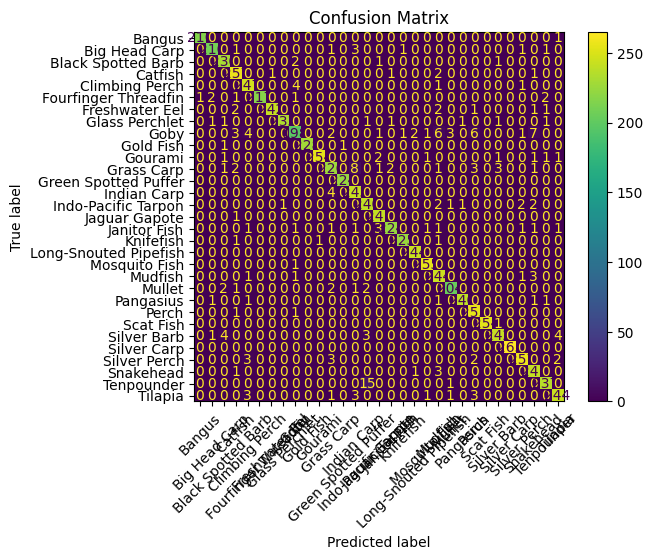

                       precision    recall  f1-score   support

               Bangus       1.00      1.00      1.00       217
        Big Head Carp       0.98      0.96      0.97       218
   Black Spotted Barb       0.96      0.98      0.97       234
              Catfish       0.95      0.98      0.96       262
       Climbing Perch       0.95      0.98      0.96       253
 Fourfinger Threadfin       1.00      0.97      0.98       224
       Freshwater Eel       1.00      0.97      0.98       249
       Glass Perchlet       1.00      0.97      0.98       240
                 Goby       0.95      0.84      0.89       235
            Gold Fish       1.00      0.99      1.00       230
              Gourami       1.00      0.97      0.98       262
           Grass Carp       0.94      0.91      0.93       248
 Green Spotted Puffer       1.00      1.00      1.00       224
          Indian Carp       0.94      0.98      0.96       247
  Indo-Pacific Tarpon       0.92      0.96      0.94  

In [ ]:
# 11. Evaluate
y_pred = np.argmax(model.predict(X_val), axis=1)
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_val, y_pred, target_names=le.classes_))

In [ ]:
# AUC-ROC Score
y_probs = model.predict(X_val)
auc_score = roc_auc_score(y_val, y_probs, multi_class='ovr')
print("AUC-ROC Score:", auc_score)

237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
AUC-ROC Score: 0.9996783039327959


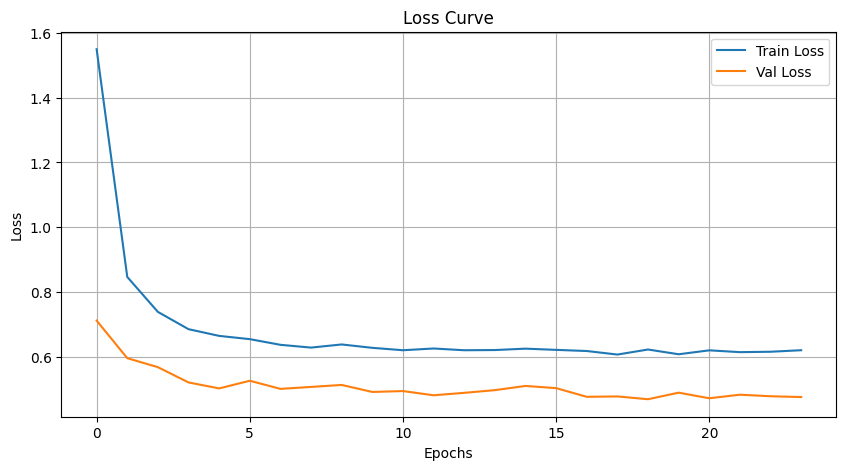

In [ ]:
# 12. Plot Learning Curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()